# Final project -- Numerical Analysis -- 2020/2021

## General goal

Consider the hyper-cube $\Omega := [-1,1]^d$ in dimension `d`.

Given a function $f: \Omega \mapsto R$, find $u: \Omega \mapsto R$ such that 

$
- \Delta u  + u = f, \text{ in } \Omega
$

$
\frac{\partial u}{\partial n} = 0 \text{ on } \partial \Omega
$

using Chebyshev spectral elements, and in a matrix-free framework.

## Due date: 

- MHPC students: 20 February 2021
- DSSC/LM/PHD students: 1 day before the oral examination

## General definitions

We recall here some general definitions that will be useful throughout the project.

- The space $Q^p(\Omega)$ is the space of polynomials of order $p$ in each coordinate direction. The dimension of $Q^p$ is $(p+1)^d$ where $d$ is the dimension of the space. 

- A tensor product basis for $Q^p(\Omega)$ can be constructed from a basis for $P^p([-1,1])$, by arranging the indices in d-dimensional arrays, i.e., if $\{v_i\}_{i=0}^p$ is a basis for $P^p([-1,1])$, then, for example, 
$
v_{ijk} := v_i(x_0)v_j(x_1)v_k(x_2)
$
is a basis for $Q^p([-1,1]^3)$.

- Chebyshev points of type 2 are Chebishev points in one dimension that include end points. These are not minimizers of the linfty norm of the Lebesgue function (those are Chebishev points of type 1), but are minimizers of Lebesgue function when you constrain two of the points to coincide with the extremes of the interval $[-1,1]$. You can obtain those points by calling `numpy.polynomial.chebyshev.chebpts2`.

- Chebyshev spectral elements are the tensor product basis for $Q^p(\Omega)$, generated by the Lagrange basis functions constructed using as support points the Chebyshev points of type 2. In one dimension, for degree=5, npoints=6, they look like

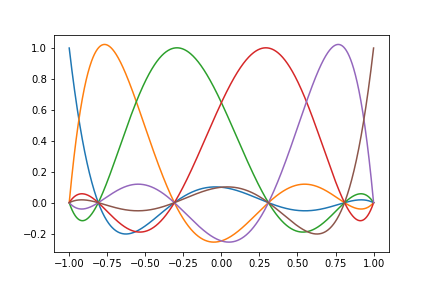

- Integration in each coordinate direction can be performed using Gauss quadrature formulas, which can be queried by the function `numpy.polynomial.legendre.leggauss`. That function returns a tuple of two objects,  containing both the quadrature points `q` and the quadrature weights `w`, i.e., `q, w = numpy.polynomial.legendre.leggauss(nq)`.

- The construction of a Lagrange basis can be done easily by calling `scipy.interpolate.lagrange(X, ei)` where `X` are the interpolation points, and `ei` is a vector containing all zeros, except a one in the position corresponding to the index i. For example, the following code 

~~~
X = numpy.polynomial.chebyshev.chebpts2(6)
e_3 = zeros((6,))
e_3[3] = 1

B_3 = lagrange(X, e_3)
B_3_prime = polyder(B_3)

x = linspace(-1,1,501)
plot(x, B_3(x))
plot(X, 0*X, 'ro')
figure()
plot(x, B_3_prime(x))
plot(X, 0*X, 'ro')
~~~

will produce the following pictures

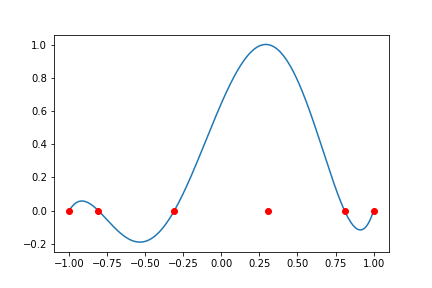

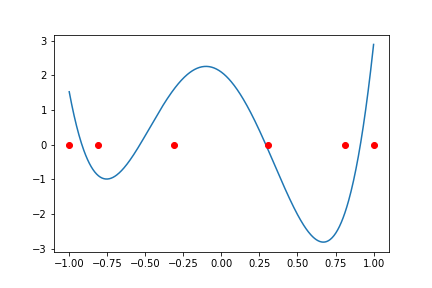

Which correspond to the fourth (`index=3`) Chebishev spectral basis function and its derivative, for the space $P^5([-1,1])$.

The functions `B_3` and `B_3_prime` computed above are callable functions, i.e., you can evaluate the basis and its derivative as normal functions, and they accept as input numpy arrays.

## Weak formulation

The weak form of the problem reads:

Given $f:\Omega \mapsto R$, find $u\in H^1(\Omega)$ such that

$
\int_\Omega \nabla u \cdot \nabla v + \int_\Omega u v = \int_\Omega f v \qquad \forall v \in H^1(\Omega)
$

## Discrete weak formulation (one dimensional case)

Given a finite dimensional space $V_h \subset H^1([-1,1])$ such that  $V_h = \text{span}\{v_i\}_{i=0}^p$, then
the discrete problem reads:

Find $u$ such that

$
A u = f 
$

where $A$ is a matrix in  $R^{(p+1)\times(p+1)}$  and $f$ is a vector in $R^{(p+1)}$ 

$
A_{ij} = \int_\Omega \nabla v_j \cdot \nabla v_i+\int_\Omega  v_j  v_i, \qquad f_i = \int_\Omega f v_i
$

that is (using a quadrature with $q_\alpha$ and $w_\alpha$ as points and weights):

$
A_{ij} = \sum_{\alpha=0}^{nq-1}\left( v'_j(q_\alpha) v'_i(q_\alpha)+  v_j(q_\alpha)  v_i(q_\alpha)\right)w_\alpha
$

$
f_{i} = \sum_{\alpha=0}^{nq-1} v_j(q_\alpha) f(q_\alpha) w_\alpha
$

Let's assume we have computed the matrices $B_{i\alpha} := v_i(q_\alpha)$, and $D_{i\alpha} := v'_i(q_\alpha)$ containing the evaluation of all basis functions and of their derivatives in the quadrature points $q_\alpha$.  

The matrix $A$ can then be written as

$
A_{ij} = \sum_\alpha \left(D_{i\alpha} D_{j\alpha} w_\alpha + B_{i\alpha} B_{j\alpha} w_\alpha\right) = K_{ij} + M_{ij}
$

where $K$ is usually known as the one dimensional stiffness matrix, and $M$ as the one dimensional mass matrix:


$
K_{ij} = \sum_\alpha \left(D_{i\alpha} D_{j\alpha} w_\alpha \right)
$


$
M_{ij} = \sum_\alpha \left(B_{i\alpha} B_{j\alpha} w_\alpha \right)
$

Using numpy and Lapack, these can be computed efficiently by calling `einsum`:

~~~
K = einsum('iq, q, jq', D, w, D)
M = einsum('iq, q, jq', B, w, B)
~~~

where the function `einsum` interprets the first argument (a string) as a list of indices over which sum should occur. The list must be of the same length of the other arguments (3 in this case), and the number of indices for each entry musth match the input (i.e., `iq` for `D`, and `q` for `w`). The three arrays are multiplied entry by entry, and if an index is repeated in the description, those entries are summed over (see the documentation).

## Higher dimensional case

If we have already computed the one dimensional matrices $B_{i\alpha} = v_i(q_\alpha)$ and $D_{i\alpha} := v'_i(q_\alpha)$ we can compute easily the 2 and 3 dimensional versions of the stiffness, mass, and system matrices.

In particular, defining $q_{\alpha\beta} := (q_\alpha, q_\beta)$, and $w_{\alpha\beta} = w_\alpha w_\beta$, we have

$\nabla v_{ij}(q_{\alpha\beta}) \cdot \nabla v_{kl}(q_{\alpha\beta}) := v'_i(q_{\alpha})v_j(q_{\beta})v'_k(q_{\alpha})v_l(q_{\beta}) + v_i(q_{\alpha})v'_j(q_{\beta})v_k(q_{\alpha})v'_l(q_{\beta})$. 

Integrating with quadrature twice (once for each dimension), we get:

$
K_{ij,kl} := \sum_q \sum_p v'_i(X_q)v_j(X_p)v'_k(X_q)v_l(X_p) + v_i(X_q)v'_j(X_p)v_k(X_q)v'_l(X_p) w_p w_q
$

These are easily expressed directly through python `einsum`, i.e., 

```
KM = einsum('iq, jp, q, p, kq, lp -> ijkl', D, B, w, w, D, B)
MK = einsum('iq, jp, q, p, kq, lp -> ijkl', D, B, w, w, B, D)
KK = KM+MK
```

Or, if we have already the one dimensional matrices $K_{ij}$ and $M_{ij}$, then the above become:

$
A_{ij,kl} := K_{ik}M_{jl} + M_{ik}K_{jl} + M_{ik}M_{jl}
$

which, using the `einsum` command, becomes:

```
KM = einsum('ik, jl -> ijkl', K, M)
MK = einsum('ik, jl -> ijkl', M, K)
MM = einsum('ik, jl -> ijkl', M, M)
KK = KM+MK
AA = KK+MM

```

The resulting array can be reshaped to a two dimensional matrix by calling `AA.reshape((n**2, n**2))`, and solved for using `linalg.solve`.

Similarly in 3 dimensions:


$
A_{ijk,lmn} := (K_{il}M_{jm}M_{kn}+M_{il}K_{jm}M_{kn}+M_{il}M_{jm}K_{kn})+M_{il}M_{jm}M_{kn}
$

Sums of the kind $D_{ijk,lmn} = A_{il}B_{jm}C_{kn}$ can be expressed using `einsum` as

```
D = einsum('il, jm, kn -> ijklmn', A, B, C)
```

And the resulting six-dimensional array can be reshaped to a matrix by calling `D.reshape((n**3, n**3))`.

## Intermediate assignments

### 1. One dimensional matrices
Write a function that, given the number of Chebishev points `n`, returns `K`, `M`, and `A` for a one dimensional problem, integrated exactly using Gauss quadrature formulas with the correct number of quadrature points 

In [1]:
#%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate
import time
from numba import jit, njit, prange, cuda

#reload stored variables, so that plots can be regenerated without running the benchmarks again
%store -r

In [4]:
def compute_one_dimensional_matrices(nipts, nqpts=None):
    ipts = np.polynomial.chebyshev.chebpts2(nipts)
    
    if not nqpts:
        nqpts = nipts - 1
    qpts, qws = np.polynomial.legendre.leggauss(nqpts)
    
    B = np.empty((nipts, nqpts), dtype=np.float64)
    D = np.empty((nipts, nqpts), dtype=np.float64)
    
    iselect = np.zeros_like(ipts, dtype=np.float64)
    for i in range(nipts):
        iselect[i] = 1.0
        ibasis = scipy.interpolate.lagrange(ipts, iselect)
        iselect[i] = 0.0
        
        B[i, :] = ibasis(qpts)
        D[i, :] = np.polyder(ibasis)(qpts)
        
    M = np.einsum("iq, q, jq", B, qws, B)
    K = np.einsum("iq, q, jq", D, qws, D)
    
    return K, M, M + K

### 2. Error in one dimension

Using 

$
u_{exact}(x) = \cos(\pi x)
$

as the exact solution, compute the forcing term $f$ that should go on the right hand side of the system to ensure that the exact solution is $u$, i.e., $f = -\Delta u + u$  

Use $f$ to compute the right hand side of your problem, and solve the problem (using `linalg.solve`) for increasing numbers of Chebishev points. Compute the $L^2$ error between the exact solution and the computed approximatio, using a higher order quadrature w.r.t. what you used to assemble the matrices. 

Plot the error as a function of $n$, for $n$ in $[10,...,20]$.

In [21]:
def exact_one_d(x):
    return np.cos(np.pi * x)
    
def rhs_one_d(x):
    return np.cos(np.pi * x) * (1.0 + np.pi ** 2)

def compute_error_one_d(n, exact, rhs):
    nipts = n
    ipts = np.polynomial.chebyshev.chebpts2(nipts)
    
    nqpts = nipts - 1
    qpts, qws = np.polynomial.legendre.leggauss(nqpts)
    
    nqpts_err = 2 * nipts
    qpts_err, qws_err = np.polynomial.legendre.leggauss(nqpts_err)
    
    B = np.empty((nipts, nqpts), dtype=np.float64)
    Be = np.empty((nqpts_err, nipts), dtype=np.float64)
    
    iselect = np.zeros_like(ipts, dtype=np.float64)
    for i in range(nipts):
        iselect[i] = 1.0
        ibasis = scipy.interpolate.lagrange(ipts, iselect)
        iselect[i] = 0.0
        
        B[i, :] = ibasis(qpts)
        Be[:, i] = ibasis(qpts_err)
    
    K, M, A = compute_one_dimensional_matrices(nipts)
    
    u = scipy.linalg.solve(A, B @ (rhs(qpts) * qws))
    
    return np.sqrt(np.sum(((exact(qpts_err) - (Be @ u))**2) * qws_err))

In [14]:
try:
    len(error_cos1d)
except NameError:
    error_cos1d = dict()

for n in range(10, 21):
    error_cos1d[n] = compute_error_one_d(n, exact_one_d, rhs_one_d)
%store error_cos1d

Stored 'error_cos1d' (dict)


In [15]:
def dict2arrays(d):
    return np.asarray(list(d.keys())), np.asarray(list(d.values()))

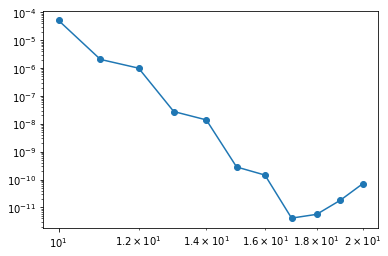

In [16]:
x, y = dict2arrays(error_cos1d)
plt.loglog(x, y, "o-")

### 3. Two dimensional matrices

Write a function that, given the number of Chebishev points `n` per each coordinate direction, returns `K`, `M`, and `A` for a two dimensional problem, integrated exactly using Gauss quadrature formulas with the correct number of quadrature points (as matrices, i.e., reshaped to be two dimensional)

In [17]:
def compute_two_dimensional_matrices(nipts, nqpts=None):
    if not nqpts:
        nqpts = nipts
        
    K, M, A = compute_one_dimensional_matrices(nipts, nqpts)
    
    newshape = (nipts**2, nipts**2)
    
    KM = np.einsum("ik, jl -> ijkl", K, M)
    
    KK = KM + KM.T
    KK = KK.reshape(newshape)
    MM = np.einsum("ik, jl -> ijkl", M, M).reshape(newshape)
    
    return KK, MM, MM + KK

#compute_two_dimensional_matrices(20)

### 3. Error in two dimension

Using 

$
u_{exact}(x) = \cos(\pi x_0)\cos(\pi x_1)
$

as the exact solution, compute the forcing term $f$ that should go on the right hand side of the system to ensure that the exact solution is $u$, i.e., $f = -\Delta u + u$  

Use $f$ to compute the right hand side of your problem, and solve the problem (using `linalg.solve`) for increasing numbers of Chebishev points. Compute the $L^2$ error between the exact solution and the computed approximatio, using a higher order quadrature w.r.t. what you used to assemble the matrices. 

A solution should look like:

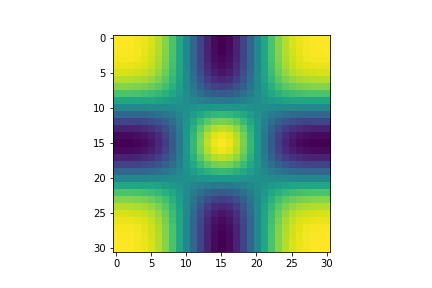

The plot was obtained as `imshow(u.reshape((n,n))`.

Plot the error as a function of $n$, for $n$ in $[10,...,20]$.

In [18]:
def exact_two_d(x):
    #return np.cos(np.pi * x[0, :]) * np.cos(np.pi * x[1, :])
    return np.prod(np.cos(np.pi * x), axis=0)
    
def rhs_two_d(x):
    return exact_two_d(x) * (1 + 2 * np.pi**2)

def compute_error_two_d(nipts, exact, rhs):
    ipts = np.polynomial.chebyshev.chebpts2(nipts)
    
    nqpts = nipts
    qpts, qws = np.polynomial.legendre.leggauss(nqpts)
    
    nqpts_err = 2 * nipts
    qpts_err, qws_err = np.polynomial.legendre.leggauss(nqpts_err)
    
    B = np.empty((nipts, nqpts), dtype=np.float64)
    Be = np.empty((nqpts_err, nipts), dtype=np.float64)
    
    iselect = np.zeros_like(ipts, dtype=np.float64)
    for i in range(nipts):
        iselect[i] = 1.0
        ibasis = scipy.interpolate.lagrange(ipts, iselect)
        iselect[i] = 0.0
        
        B[i, :] = ibasis(qpts)
        Be[:, i] = ibasis(qpts_err)
    
    BBe = np.einsum("ik, jl -> ijkl", Be, Be)
    BBe = BBe.reshape((nqpts_err**2, nipts**2))
    
    ipts2d = np.array(np.meshgrid(ipts, ipts), dtype=np.float64)
    ipts2d = ipts2d.reshape((2, nipts**2))
    
    KK, MM, AA = compute_two_dimensional_matrices(nipts, nqpts)
    
    qpts2d = np.array(np.meshgrid(qpts, qpts), dtype=np.float64)
    qpts2d = qpts2d.reshape((2, nqpts**2))
    
    ff = rhs(qpts2d).reshape((nqpts, nqpts))
    FF = np.einsum("iq, q, qp, p, jp-> ij", B, qws, ff, qws, B)
    
    uu = scipy.linalg.solve(AA, FF.reshape(nipts**2))
    
    qpts_err2d = np.array(np.meshgrid(qpts_err, qpts_err), dtype=np.float64)
    qpts_err2d = qpts_err2d.reshape((2, nqpts_err**2))
    
    qws_err2d = np.einsum("i, j -> ij", qws_err, qws_err)
    qws_err2d = qws_err2d.reshape((nqpts_err**2))
    
    return np.sqrt(np.sum(((exact(qpts_err2d) - (BBe @ uu))**2) * qws_err2d))

In [20]:
try:
    len(error_cos2d)
except NameError:
    error_cos2d = dict()

for n in range(10, 21):
    error_cos2d[n] = compute_error_two_d(n, exact_two_d, rhs_two_d)
%store error_cos2d

Stored 'error_cos2d' (dict)


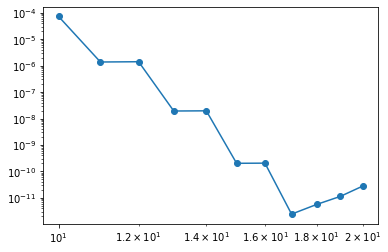

In [84]:
x, y = dict2arrays(error_cos2d)
plt.loglog(x, y, "o-")

### 4. Conjugate gradient

The conjugate gradient method does not require the knowledge of the matrix, but only of the result of the matrix vector product with the system matrix A. 

Implement a version of the conjugate gradient method that solves the linear system of the two dimensional problem (up to a given tolerance) by only using a function that implements the matrix vector product, i.e., given a `matvec` function, for example defined by  

~~~
def matvec(src):
    return A.dot(src)
~~~

build a conjugate gradient method that only uses the function `matvec` to evaluate `A.dot(src)`. 

In [26]:
def matvec(src):
    return A.dot(src)

def cg(matvec, b, x0, tol=1e-05, maxiter=10000):
    # inside this function, you can call matvec(b) to evaluate the matrix vector 
    x = x0.copy()
    r = b - matvec(x)
    
    e = np.linalg.norm(r, 2)
    if e < tol:
        return x, 0, e
    
    p = r.copy()
    
    it = 1
    while it <= maxiter:
        Ap = matvec(p)
        a = p.dot(r) / p.dot(Ap)
        
        x += a * p
        r -= a * Ap
        
        e = np.linalg.norm(r, 2)
        if e < tol:
            break
        
        be = Ap.dot(r) / Ap.dot(p)
        p = r - be * p
            
        it += 1
    
    return x, it, e

def test_cg(nipts, exact, rhs):
    ipts = np.polynomial.chebyshev.chebpts2(nipts)
    
    nqpts = nipts - 1
    qpts, qws = np.polynomial.legendre.leggauss(nqpts)
    
    B = np.empty((nipts, nqpts), dtype=np.float64)
    
    iselect = np.zeros_like(ipts, dtype=np.float64)
    for i in range(nipts):
        iselect[i] = 1.0
        ibasis = scipy.interpolate.lagrange(ipts, iselect)
        iselect[i] = 0.0
        
        B[i, :] = ibasis(qpts)

    f = B @ (rhs(qpts) * qws)
    
    u = scipy.linalg.solve(A, f)
    u_cg, it, e = cg(matvec, f, np.zeros_like(f))
    e_cg = np.linalg.norm(u-u_cg, 2)
    print(f"finished in {it} iterations, diff {e_cg}, tolerance {e}")

In [27]:
nipts = 45
K, M, A = compute_one_dimensional_matrices(nipts)
print(f"cond(A): {np.linalg.cond(A)}")

test_cg(nipts, exact_one_d, rhs_one_d)

cond(A): 658853838925153.4
finished in 10001 iterations, diff 35.40065506334376, tolerance 2.2279667166491937


### 5. "Matrix free" evaluation

Instead of assembling the two (or three dimensional) matrix, and then compute the matrix vector product using `A.dot(v)`, we can exploit the tensor product structure of the problem, and gain some computational time.

In particular, we exploit the fact that the two dimensional matrix is a `reshape` of the array

$
A_{ij,kl} := K_{ik}M_{jl} + M_{ik}K_{jl} + M_{ik}M_{jl}
$

which is constructed using the one dimensional matrices assembled at step 1.

Given an array `v`, it can be reshaped to a matrix of coefficients $v_{ij}$ in $R^{n\times n}$, and we can compute `A.dot(v)` as the sum $w_{ij} = \sum_{kl} A_{ij,kl} v_{kl}$

So `A.dot(v)` reduces to  series of one dimensional matrix-matrix and matrix vector products:


$
w_{ij}  = \sum_{kl} A_{ij,kl} v_{kl} = \sum_{kl} (K_{ik}M_{jl}v_{kl} + M_{ik}K_{jl}v_{kl} + M_{ik}M_{jl}v_{kl})
$

which can be rearranged as 

~~~
def matvec(vinput):
    v = vinput.reshape((n,n))

    Mv = M.dot(v) # result is n x n 
    Kv = K.dot(v) # result is n x n 

    # KT_Mv = K.dot(Mv)  # K is symmetric
    # MT_Kv = M.dot(Kv)  # M is symmetric
    # MT_Mv = M.dot(Mv)  # M is symmetric

    u = K.dot(Mv)
    u += M.dot(Kv) 
    u += M.dot(Mv)
    return u.reshape((n**2,))
~~~

Make a comparison of the timings between using the full two dimensional matrix `A` to compute the matrix vector product, VS using the compressed version above, as we increase `n` from 50 to 100.

In [28]:
def matvec2(vinput):
    v = vinput.reshape((n, n))
    
    #u = K @ v @ M
    #u += M @ v @ K
    #u += M @ v @ M
    
    u = (K + M) @ v @ M + M @ v @ K
    
    return u.reshape((n**2))

In [29]:
ns = [i for i in range(50, 101, 5)]
nrepeats = 10

t_matbuild2_1d = dict()
t_matbuild2_2d = dict()

t_matmul2 = dict()
t_matfree2 = dict()

e_matfree2 = dict()
e_explicit2 = dict()

for n in ns:
    print(f"n: {n}")
    
    t = -time.perf_counter()
    K, M, A = compute_one_dimensional_matrices(n, n)
    t += time.perf_counter()
    t_matbuild2_1d[n] = t
    
    newshape = (n**2, n**2)
    
    t = -time.perf_counter()
    KK, MM, AA = compute_two_dimensional_matrices(n, n)
    t += time.perf_counter()
    t_matbuild2_2d[n] = t
    
    vinput = np.ones(n**2)
    
    print(f"matmul started")
    t = -time.perf_counter()
    for i in range(nrepeats):
        w_matmul = AA @ vinput
    t += time.perf_counter()
    t_matmul2[n] = t/nrepeats
    
    print(f"matfree started")
    t = -time.perf_counter()
    for i in range(nrepeats):
        w_matfree = matvec2(vinput)
    t += time.perf_counter()
    t_matfree2[n] = t/nrepeats
    e_matfree2[n] = np.linalg.norm(w_matmul-w_matfree, 2)
    
    print(f"cooldown")
    time.sleep(n/10)
    
%store t_matbuild2_1d
%store t_matbuild2_2d

%store t_matmul2
%store t_matfree2

%store e_matfree2

n: 50
matmul started
matfree started
cooldown
n: 55
matmul started
matfree started
cooldown
n: 60
matmul started
matfree started
cooldown
n: 65
matmul started
matfree started
cooldown
n: 70
matmul started
matfree started
cooldown
n: 75
matmul started
matfree started
cooldown
n: 80
matmul started
matfree started
cooldown
n: 85
matmul started
matfree started
cooldown
n: 90
matmul started
matfree started
cooldown
n: 95
matmul started
matfree started
cooldown
n: 100
matmul started
matfree started
cooldown
Stored 't_matbuild2_1d' (dict)
Stored 't_matbuild2_2d' (dict)
Stored 't_matmul2' (dict)
Stored 't_matfree2' (dict)
Stored 'e_matfree2' (dict)


Times are the average of 10 runs, measured with an Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, 6MB cache L3, 16GB RAM  
<img style="float: left;" src="matvec2d_times_loglog.png">

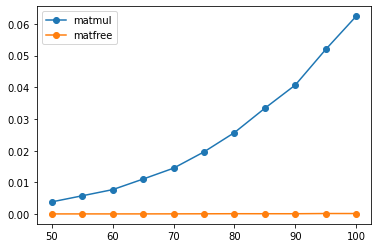

In [31]:
x, y = dict2arrays(t_matmul2)
plt.plot(x, y, "o-", label="matmul")

x, y = dict2arrays(t_matfree2)
plt.plot(x, y, "o-", label="matfree")

plt.legend()

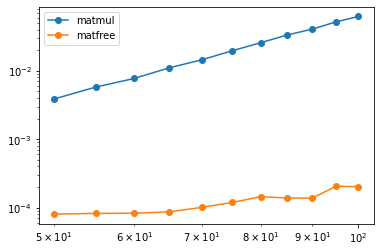

In [32]:
x, y = dict2arrays(t_matmul2)
plt.loglog(x, y, "o-", label="matmul")

x, y = dict2arrays(t_matfree2)
plt.loglog(x, y, "o-", label="matfree")

plt.legend()

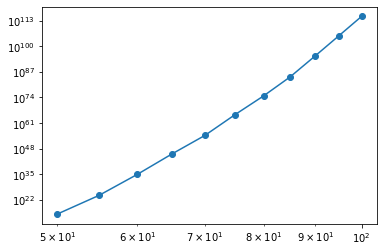

In [30]:
x, y = dict2arrays(e_matfree2)
plt.loglog(x, y, "o-", scaley="log", label="matfree")

### 6. "Matrix free" evaluation for three dimensional problems (mandatory for MHPC, optional for others)

Looking at https://www.geeksforgeeks.org/running-python-script-on-gpu/, implement the same matrix free solver for three dimensional problems, exploiting just in time compilation, numba, and (optionally) GPU acceleration (if you have access to a GPU). 

Compare the timings you get for a fixed number of matrix vector products as n increases from 50 to 100 for the cases 

1. matrix based (assemble the three dimensional A, measure time of 100 A.dot(v)
2. matrix free, pure numpy (using techinque above, measure time 100 applications of matvec(v))
3. matrix free, numba+jit on CPU (measure time 100 applications of matvec(v))
4. (optional) matrix free, numba+jit on GPU (measure time 100 applications of matvec(v))

Comment on your findings.

In [85]:
def compute_three_dimensional_matrices(nipts, nqpts=None):
    if not nqpts:
        nqpts = nipts
        
    K, M, A = compute_one_dimensional_matrices(nipts, nqpts)
    
    newshape = (nipts**3, nipts**3)
    
    KMM = np.einsum("il, jm, kn -> ijklmn", K, M, M).reshape(newshape)
    MKM = np.einsum("il, jm, kn -> ijklmn", M, K, M).reshape(newshape)
    MMK = np.einsum("il, jm, kn -> ijklmn", M, M, K).reshape(newshape)
    
    KKK = KMM + MKM + MMK
    
    MMM = np.einsum("il, jm, kn -> ijklmn", M, M, M).reshape(newshape)
    
    return KKK, MMM, MMM + KKK

#this is the basic matfree implementation, based on transposing the matrices 
#to expose the indexes to be erased, one at a time
def matvec3(vinput, M, K):
    #the same can be obtained with tensordot; it doesn't require transpositions nor reshape
    N = round(vinput.shape[0]**(1/3))

    #v is indexed as lm,n
    v = vinput.reshape((N * N, N))
    #combine with 'rightmost' matrix, indexed by k,n <-> n,k due to symmetry
    #results are indexed by l,m,k
    Mv = (v @ M).reshape((N, N, N))
    Kv = (v @ K).reshape((N, N, N))
    
    #roll indexing l,m,k -> l,k,m; reshape to lk,m
    Mv = np.moveaxis(Mv, 1, 2).reshape((N * N, N))
    Kv = np.moveaxis(Kv, 1, 2).reshape((N * N, N))
    
    #combine with 'middle' matrix, indexed by j,m <-> m,j
    #results are indexed by l,k,j
    MMv = (Mv @ M).reshape((N, N, N))
    KMv = (Mv @ K).reshape((N, N, N))
    MKv = (Kv @ M).reshape((N, N, N))
                                       
    #roll indexing l,k,j -> l,j,k; reshape to l,jk
    MMv = np.moveaxis(MMv, 1, 2).reshape((N, N * N))
    KMv = np.moveaxis(KMv, 1, 2).reshape((N, N * N))
    MKv = np.moveaxis(MKv, 1, 2).reshape((N, N * N))
    
    #combine with 'leftmost' matrix, indexed by i,l <-> l,i
    #results are indexed by i,j,k
    KMMv = (K @ MMv).reshape((N, N, N))
    MKMv = (M @ KMv).reshape((N, N, N))
    MMKv = (M @ MKv).reshape((N, N, N))
    MMMv = (M @ MMv).reshape((N, N, N))
    
    return (KMMv + MKMv + MMKv + MMMv).reshape((N**3))

#using tensordot allows to reduce the transposing and reshaping
#surprisingly, benchmarks show that it is slightly slower than matvec3
def matvec3_tdot(vinput, M, K):
    N = round(vinput.shape[0]**(1/3))

    #v is indexed as l,m,n
    v = vinput.reshape((N, N, N))
    #combine with 'rightmost' matrix, indexed by k,n <-> n,k due to symmetry
    #results are indexed by l,m,k
    Mv = np.tensordot(v, M, ([2], [0]))
    Kv = np.tensordot(v, K, ([2], [0]))
    
    #combine with 'middle' matrix, indexed by j,m <-> m,j
    #results are indexed by l,k,j; transpose to ljk
    MMv = np.tensordot(Mv, M, ([1], [0])).transpose((0, 2, 1))
    KMv = np.tensordot(Mv, K, ([1], [0])).transpose((0, 2, 1))
    MKv = np.tensordot(Kv, M, ([1], [0])).transpose((0, 2, 1))
    
    #combine with 'leftmost' matrix, indexed by i,l <-> l,i
    #results are indexed by i,j,k
    KMMv = np.tensordot(K, MMv, ([0], [0]))
    MKMv = np.tensordot(M, KMv, ([0], [0]))
    MMKv = np.tensordot(M, MKv, ([0], [0]))
    MMMv = np.tensordot(M, MMv, ([0], [0]))
    
    return (KMMv + MKMv + MMKv + MMMv).reshape((N**3))

#Numba doesn't support moveaxis, switched to transpose
#reshape is not supported unless the array is contiguous in memory
@njit
def matvec3_jit(vinput, M, K):
    N = round(vinput.shape[0]**(1/3))
    
    v = np.zeros((N * N, N), dtype=np.float64)
    Mv = np.zeros((N, N, N), dtype=np.float64)
    Kv = np.zeros((N, N, N), dtype=np.float64)
    
    MMv = np.zeros((N, N, N), dtype=np.float64)
    KMv = np.zeros((N, N, N), dtype=np.float64)
    MKv = np.zeros((N, N, N), dtype=np.float64)
    
    KMMv = np.zeros((N, N, N), dtype=np.float64)
    MKMv = np.zeros((N, N, N), dtype=np.float64)
    MMKv = np.zeros((N, N, N), dtype=np.float64)
    MMMv = np.zeros((N, N, N), dtype=np.float64)
    
    v[:, :] = vinput.reshape((N * N, N))
    Mv = (v @ M).reshape((N, N, N)).transpose((0, 2, 1))
    Kv = (v @ K).reshape((N, N, N)).transpose((0, 2, 1))
    
    Mv = np.ascontiguousarray(Mv).reshape((N * N, N))
    Kv = np.ascontiguousarray(Kv).reshape((N * N, N))
    
    MMv = (Mv @ M).reshape((N, N, N)).transpose((0, 2, 1))
    KMv = (Mv @ K).reshape((N, N, N)).transpose((0, 2, 1))
    MKv = (Kv @ M).reshape((N, N, N)).transpose((0, 2, 1))
                                       
    MMv = np.ascontiguousarray(MMv).reshape((N, N * N))
    KMv = np.ascontiguousarray(KMv).reshape((N, N * N))
    MKv = np.ascontiguousarray(MKv).reshape((N, N * N))
    
    KMMv = (K @ MMv).reshape((N, N, N))
    MKMv = (M @ KMv).reshape((N, N, N))
    MMKv = (M @ MKv).reshape((N, N, N))
    MMMv = (M @ MMv).reshape((N, N, N))
    
    return (KMMv + MKMv + MMKv + MMMv).reshape((N**3))

#enable implicit (decided by the compiler) thread parallelism
@njit(parallel=True)
def matvec3_jitpar(vinput, M, K):
    N = round(vinput.shape[0]**(1/3))
    
    v = np.zeros((N * N, N), dtype=np.float64)
    Mv = np.zeros((N, N, N), dtype=np.float64)
    Kv = np.zeros((N, N, N), dtype=np.float64)
    
    MMv = np.zeros((N, N, N), dtype=np.float64)
    KMv = np.zeros((N, N, N), dtype=np.float64)
    MKv = np.zeros((N, N, N), dtype=np.float64)
    
    KMMv = np.zeros((N, N, N), dtype=np.float64)
    MKMv = np.zeros((N, N, N), dtype=np.float64)
    MMKv = np.zeros((N, N, N), dtype=np.float64)
    MMMv = np.zeros((N, N, N), dtype=np.float64)
    
    v[:, :] = vinput.reshape((N * N, N))
    Mv = (v @ M).reshape((N, N, N)).transpose((0, 2, 1))
    Kv = (v @ K).reshape((N, N, N)).transpose((0, 2, 1))
    
    Mv = np.ascontiguousarray(Mv).reshape((N * N, N))
    Kv = np.ascontiguousarray(Kv).reshape((N * N, N))
    
    MMv = (Mv @ M).reshape((N, N, N)).transpose((0, 2, 1))
    KMv = (Mv @ K).reshape((N, N, N)).transpose((0, 2, 1))
    MKv = (Kv @ M).reshape((N, N, N)).transpose((0, 2, 1))
                                       
    MMv = np.ascontiguousarray(MMv).reshape((N, N * N))
    KMv = np.ascontiguousarray(KMv).reshape((N, N * N))
    MKv = np.ascontiguousarray(MKv).reshape((N, N * N))
    
    KMMv = (K @ MMv).reshape((N, N, N))
    MKMv = (M @ KMv).reshape((N, N, N))
    MMKv = (M @ MKv).reshape((N, N, N))
    MMMv = (M @ MMv).reshape((N, N, N))
    
    return (KMMv + MKMv + MMKv + MMMv).reshape((N**3))

@cuda.jit
def matvec3_cudakernel(v, u, M, K):
    N = v.shape[0] 
    #i = cuda.blockDim.x * cuda.blockIdx.x + cuda.threadIdx.x
    #j = cuda.blockDim.y * cuda.blockIdx.y + cuda.threadIdx.y
    #k = cuda.blockDim.z * cuda.blockIdx.z + cuda.threadIdx.z
    (i, j, k) =  cuda.grid(3)
    
    #basic implementation; one thread for each element of u
    if i < N and j < N and k < N:
        T = 0
        for l in range(N):
            for m in range(N):
                KM = K[i, l] * M[j, m]
                MK = M[i, l] * K[j, m]
                MM = M[i, l] * M[j, m]
                
                for n in range(N):  
                    T += (KM + MK) * M[k, n] + MM * (K[k, n] + M[k, n]) * v[l, m, n]
        u[i, j, k] = T
        
#numba 0.51.2 (in the conda distribution) is incompatible with 11.2 NVidia toolkit
def matvec3_cuda(vinput, M, K):
    n = round(vinput.shape[0]**(1/3))
    v = vinput.reshape((n, n, n))
    u = np.zeros_like(v)
    
    #hard limit is (usually) 1024 threads per block
    blockSize = 8
    #assume that n fits the maximum index for all three dimensions
    gridSize = n // blockSize
    if n % blockSize:
        gridSize += 1
    
    blockDim = (blockSize, blockSize, blockSize)
    gridDim = (gridSize, gridSize, gridSize)
    
    #matvec3_cudakernel[gridDim, blockDim](v, u, M, K)
    
    return u.reshape((n**3))

n = 2
#"just" in time, but compile now
K, M, A = compute_one_dimensional_matrices(n)
vinput = np.ones((n**3))

matvec3_jit(vinput, M, K)
matvec3_jitpar(vinput, M, K)
#matvec3_cuda(vinput, M, K)

print("kernels compiled")

kernels compiled


In [94]:
ns = [i for i in range(10, 101, 5)]
nrepeats = 100

t_matbuild3_1d = dict()
t_matbuild3_3d = dict()

t_matmul3 = dict()
t_matfree3 = dict()
t_tdot3 = dict()
t_jit3 = dict()
t_jitpar3 = dict()
t_cuda3 = dict()

e_matfree3 = dict()
e_tdot3 = dict()
e_jit3 = dict()
e_jitpar3 = dict()
e_cuda3 = dict()

for n in ns:
    #full matrix multiplication requires storage for n**6 doubles
    #only feasible on clusters, or very small problems
    domatmul = (8*n**6 < 10**9)
    print(f"n: {n}")
    
    t = -time.perf_counter()
    K, M, A = compute_one_dimensional_matrices(n, n)
    t += time.perf_counter()
    t_matbuild3_1d[n] = t
    
    newshape = (n**3, n**3)
    
    if domatmul:
        t = -time.perf_counter()
        KKK, MMM, AAA = compute_three_dimensional_matrices(n)
        t += time.perf_counter()
        t_matbuild3_3d[n] = t
        
    vinput = np.array([i for i in range(n**3)], dtype=np.float64)
    
    if domatmul:
        t = -time.perf_counter()
        for i in range(nrepeats):
            w_matmul = AAA @ vinput
        t += time.perf_counter()
        t_matmul3[n] = t/nrepeats
        
    t = -time.perf_counter()
    for i in range(nrepeats):
        w_matfree = matvec3(vinput, M, K)
    t += time.perf_counter()
    t_matfree3[n] = t/nrepeats
    if domatmul:
        e_matfree3[n] = np.linalg.norm(w_matmul-w_matfree, 2)
    
    t = -time.perf_counter()
    for i in range(nrepeats):
        w_tdot = matvec3_tdot(vinput, M, K)
    t += time.perf_counter()
    t_tdot3[n] = t/nrepeats
    if domatmul:
        e_tdot3[n] = np.linalg.norm(w_matmul-w_tdot, 2)
    
    t = -time.perf_counter()
    for i in range(nrepeats):
        w_jit = matvec3_jit(vinput, M, K)
    t += time.perf_counter()
    t_jit3[n] = t/nrepeats
    if domatmul:
        e_jit3[n] = np.linalg.norm(w_matmul-w_jit, 2)
            
    t = -time.perf_counter()
    for i in range(nrepeats):
        w_jitpar = matvec3_jitpar(vinput, M, K)
    t += time.perf_counter()
    t_jitpar3[n] = t/nrepeats
    if domatmul:
        e_jitpar3[n] = np.linalg.norm(w_matmul-w_jitpar, 2)
    
    time.sleep(n / 10)
    
%store t_matbuild3_1d
%store t_matbuild3_3d

%store t_matmul3
%store t_matfree3
%store t_tdot3
%store t_jit3
%store t_jitpar3
%store t_cuda3

%store e_matfree3
%store e_tdot3
%store e_jit3
%store e_jitpar3
%store e_cuda3

n: 100
Stored 't_matbuild3_1d' (dict)
Stored 't_matbuild3_3d' (dict)
Stored 't_matmul3' (dict)
Stored 't_matfree3' (dict)
Stored 't_tdot3' (dict)
Stored 't_jit3' (dict)
Stored 't_jitpar3' (dict)
Stored 't_cuda3' (dict)
Stored 'e_matfree3' (dict)
Stored 'e_tdot3' (dict)
Stored 'e_jit3' (dict)
Stored 'e_jitpar3' (dict)
Stored 'e_cuda3' (dict)


Times are the average of 100 runs, measured with an Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, 6MB cache L3, 16GB RAM  
Due to the large memory required by the matrix multiplication method, the benchmarks for it were run only for n up to 20; parallel code uses 4 threads  
The pure-Numpy "matfree" implementation is focused on using the matrix multiplication as a library primitive  
An alternative is using tensordot, which saves some reshaping and transposing; this uses the "tdot" label  
The Numba-enabled codes "jit" and "jit(parallel)" (the latter being automatically parallelized) are functionally the same as the pure-Numpy one; however, extra calls were needed to allow the compilation  
In particular, the static calls to moveaxis were switched to object method transpose; as a limitation on reshape, the object is required to be allocated contiguously, requiring an extra copy with np.ascontiguousarray wrapping transposed objects
This also suggests that Numpy transposed matrices are obtained in-place as a view with mapped indices and the Numba-code performance will be penalised  
  
The full matrix-vector product quickly becomes infeasible, as both storage and FP operations grow as $O(n^6)$  
Matrix free computations instead require $O(n^3)$ storage and $O(n^4)$ FP operations  
Line fitting to the benchmark data (transformed with a logarithm) gave $n^{6.06}$ for the matrix-vector product, but the matrix free codes (fitted on higher, more stable values of n) place the exponent around 3  
This suggests that memory accesses are more costly than the actual FLOPs for n in the interval 70, 100  

Differences between the implementations are nost extreme and vary with $n$; "matfree" is consistently faster, except around $n=50$, where "jit(parallel)" beats it narrowly  
The procedures of the pure-Numpy methods do not translate well to Numba; possibly due to a negligible optimization margin on the matrix product, and the extra operations needed for carrying out the transpositions and reshapes  
Also, the speedup from parallelization is far from acceptable, reaching around 1.2 with 4 threads  
<img style="float: left;" src="matvec3d_times_loglog.png">

speedup 1.2028902337779872


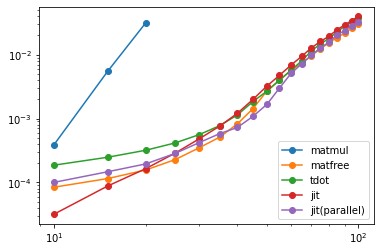

In [34]:
x, y = dict2arrays(t_matmul3)
plt.loglog(x, y, "o-", label="matmul")
x, y = dict2arrays(t_matfree3)
plt.loglog(x, y, "o-", label="matfree")
x, y = dict2arrays(t_tdot3)
plt.loglog(x, y, "o-", label="tdot")
x, y = dict2arrays(t_jit3)
plt.loglog(x, y, "o-", label="jit")
x, y = dict2arrays(t_jitpar3)
plt.loglog(x, y, "o-", label="jit(parallel)")

plt.legend()

x, y = dict2arrays(t_jit3)
x2, y2 = dict2arrays(t_jitpar3)
print(f"speedup {y[-1] / y2[-1]}")

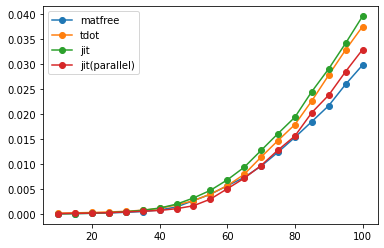

In [35]:
x, y = dict2arrays(t_matfree3)
plt.plot(x, y, "o-", label="matfree")
x, y = dict2arrays(t_tdot3)
plt.plot(x, y, "o-", label="tdot")
x, y = dict2arrays(t_jit3)
plt.plot(x, y, "o-", label="jit")
x, y = dict2arrays(t_jitpar3)
plt.plot(x, y, "o-", label="jit(parallel)")

plt.legend()

In [51]:
#inspection of exponent of time growth; matfree approaches were expected to be O(n^4)
x, y = dict2arrays(t_matmul3)
m, b = np.polyfit(np.log(x[-2:]), np.log(y[-2:]), 1)
print(f"matmul loglog slope: {m}")

x, y = dict2arrays(t_matfree3)
#filter out lower ns
nfrom = -2
m, b = np.polyfit(np.log(x[nfrom:]), np.log(y[nfrom:]), 1)
print(f"matfree loglog slope: {m}")

x, y = dict2arrays(t_jit3)
m, b = np.polyfit(np.log(x[nfrom:]), np.log(y[nfrom:]), 1)
print(f"jit loglog slope: {m}")

x, y = dict2arrays(t_jitpar3)
m, b = np.polyfit(np.log(x[nfrom:]), np.log(y[nfrom:]), 1)
print(f"jitpar loglog slope: {m}")

matmul loglog slope: 6.063813610520817
matfree loglog slope: 2.6930791206165297
jit loglog slope: 2.855734424440287
jitpar loglog slope: 2.789148671977887


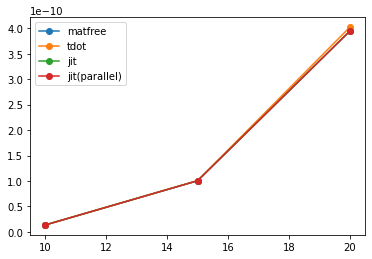

In [52]:
#inspection of difference against full matrix-vector product
x, y = dict2arrays(e_matfree3)
plt.plot(x, y, "o-", label="matfree")
x, y = dict2arrays(e_tdot3)
plt.plot(x, y, "o-", label="tdot")
x, y = dict2arrays(e_jit3)
plt.plot(x, y, "o-", label="jit")
x, y = dict2arrays(e_jitpar3)
plt.plot(x, y, "o-", label="jit(parallel)")

plt.legend()